# Определение перспективного тарифа для телеком-компании

Оператор сотовой связи "Мегалайн" предлагают два тарифных плана: "Смарт" и "Ультра". Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов и сделать вывод — какой тариф лучше.

**Данные:** выборка, в которую вошли 500 пользователей; данные о них, о тарифе, сколько звонков и сообщений каждый отправил за 2018 год.

**Ход исследования:** загрузка и обзор данных, предобработка (пропуски, аномалии), анализ тарифов в разрезе поведения клиентов, проверка гипотез.

## Предобработка данных

In [2]:
# импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns

### Пользователи

In [3]:
# запись данных из csv-файла в датафрейм   
try:
    df_users = pd.read_csv('users.csv')
except:
    df_users = pd.read_csv('/datasets/users.csv')

In [4]:
# вывод первых 10 строк таблицы с данными
df_users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [5]:
# вывод характеристик данных в датасете
df_users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


In [6]:
# получение информации о типах данных и пропусках
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Датасет *df_users* содержит следующую информацию о пользователях:
- *user_id* — уникальный идентификатор пользователя
- *first_name* — имя пользователя
- *last_name* — фамилия пользователя
- *age* — возраст пользователя (годы)
- *reg_date* — дата подключения тарифа (день, месяц, год)
- *churn_date* — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- *city* — город проживания пользователя
- *tariff* — название тарифного плана

В столбцах *churn_date* и *reg_date* даты записаны в формате object, на следующем этапе мы преобразуем эти данные в формат datetime.  

In [7]:
# подсчет уникальных значений в поле user_id
df_users['user_id'].nunique()

500

Датасет содержит 500 строк, идентификаторы пользователей не повторяются (и идут по порядку от 1000 до 1499), значит у нас есть данные о 500 пользователях. Пропусков в столбцах нет, помимо параметра *churn_date*, где пропуск несет смысловую нагрузку.  

In [8]:
# вывод самых часто встречающихся в датасете имен и фамилий
display(df_users['first_name'].value_counts().head(10))
df_users['last_name'].value_counts().head(10)

Радим       6
Леонид      5
Пётр        5
Андрей      4
Адам        4
Марта       4
Тамара      4
Мариетта    4
Всеволод    4
Рубен       4
Name: first_name, dtype: int64

Андреенко     5
Березина      3
Аркадьев      3
Булгаков      3
Соловьев      3
Алексеенко    3
Анищенко      3
Озерова       3
Абашкина      3
Аничкина      3
Name: last_name, dtype: int64

Судя по всему, поля имен и фамилий заполнены без ошибок; но при этом вывод самых частотных имен дал несколько неожиданные результаты. 

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

Text(0.5, 1.0, 'Распределение пользователей по возрасту')

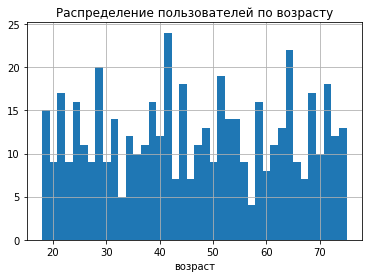

In [9]:
# вывод характеристик параметра "возраст"; построение гистограммы
display(df_users['age'].describe())
ax = df_users['age'].hist(bins=40)
ax.set_xlabel('возраст')
ax.set_title('Распределение пользователей по возрасту')

Возрастные группы распределены довольно равномерно между 18 и 75 годами, с небольшим пиком в районе 41-43 лет. 

In [10]:
# подсчет уникальных значений в столбце city
len(df_users['city'].value_counts())

76

In [11]:
# вывод 10 самых часто встречающихся городов
df_users['city'].value_counts().head(10)

Москва              99
Санкт-Петербург     39
Новосибирск         16
Омск                14
Казань              14
Уфа                 12
Краснодар           11
Набережные Челны    11
Ульяновск           11
Екатеринбург        11
Name: city, dtype: int64

In [12]:
# вывод уникальных значений в столбце city
df_users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

В выборку попали пользователи из 76 городов, при этом пятую часть составляют москвичи, на втором месте Санкт-Петербург. 

In [13]:
# вывод тарифов и их долей в датасете  
df_users.tariff.value_counts(normalize=True)

smart    0.702
ultra    0.298
Name: tariff, dtype: float64

Судя по нашей выборке, тариф "Смарт" пользуется большей популярностью - его выбрали 70% клиентов.

In [14]:
# вывод периода
print('Дата подключения: от', df_users.reg_date.min(), 'до', df_users.reg_date.max())
print('Дата прекращения пользования услугами: от', df_users[~df_users['churn_date'].isna()].churn_date.min(), 
      'до', df_users[~df_users['churn_date'].isna()].churn_date.max())

Дата подключения: от 2018-01-01 до 2018-12-31
Дата прекращения пользования услугами: от 2018-08-17 до 2018-12-30


Интересно, что все пользователи в нашей выборке подключились в 2018 году, в течение всего года. А отключения начинаются с августа 2018.

In [15]:
print('Количество отказов от услуг:') 

# подсчет количества отказов по каждому тарифу
churn_smart = df_users[df_users['tariff'] == 'smart']['churn_date'].count()
churn_ultra = df_users[df_users['tariff'] == 'ultra']['churn_date'].count()

# вычисление соотношения отказов от тарифа к общему числу пользователей тарифа 
churn_rate_smart = churn_smart / df_users[df_users['tariff'] == 'smart']['tariff'].count()
churn_rate_ultra = churn_smart / df_users[df_users['tariff'] == 'ultra']['tariff'].count()

print(f'тариф "Смарт" - {churn_smart} (доля оттока {churn_rate_smart:.2%})') 
print(f'тариф "Ультра" - {churn_ultra} (доля оттока {churn_rate_ultra:.2%})') 

Количество отказов от услуг:
тариф "Смарт" - 23 (доля оттока 6.55%)
тариф "Ультра" - 15 (доля оттока 15.44%)


Определим время, в течение которого клиенты, расторгнувшие договор, пользовались услугами. 

In [16]:
# формирование датасета
churn_users = df_users[~df_users['churn_date'].isna()]

# добавление столбца с вычислением срока
churn_users['lifetime'] = pd.to_datetime(churn_users['churn_date']) - pd.to_datetime(churn_users['reg_date'])

# вывод датасета
churn_users.sort_values(by='lifetime')

C:\Users\1\AppData\Local\Temp/ipykernel_6020/123270677.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn_users['lifetime'] = pd.to_datetime(churn_users['churn_date']) - pd.to_datetime(churn_users['reg_date'])


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,lifetime
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,5 days
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,8 days
62,1062,24,2018-12-09,Москва,Александр,Коршунов,2018-11-16,smart,23 days
242,1242,39,2018-12-21,Хабаровск,Радим,Федосеев,2018-11-18,smart,33 days
163,1163,21,2018-12-16,Москва,Лев,Вишневский,2018-11-03,smart,43 days
206,1206,35,2018-12-20,Москва,Елена,Шарапова,2018-11-03,smart,47 days
399,1399,31,2018-12-25,Уфа,Алиса,Абрашина,2018-11-06,ultra,49 days
90,1090,54,2018-12-03,Череповец,Екатерина,Астафьева,2018-10-11,ultra,53 days
232,1232,60,2018-11-30,Томск,Виктория,Ларина,2018-10-07,smart,54 days
20,1020,59,2018-12-18,Чита,Тала,Костина,2018-10-22,smart,57 days


### Звонки

In [17]:
# запись данных из csv-файла в датафрейм   
try:
    df_calls = pd.read_csv('calls.csv')
except:
    df_calls = pd.read_csv('/datasets/calls.csv')

In [18]:
# вывод первых 10 строк таблицы с данными
df_calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [19]:
# получение общей информации о таблице
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Таблица *calls* (информация о звонках) содержит такие столбцы:
- *id* — уникальный номер звонка
- *call_date* — дата звонка
- *duration* — длительность звонка в минутах
- *user_id* — идентификатор пользователя, сделавшего звонок

Датасет заполнен без пропусков, столбец call_date может потребовать преобразование в формат даты.

Проверим датасет на дубликаты:

In [20]:
# проверка
df_calls.duplicated().sum()

0

In [21]:
# подсчет уникальных пользователей в датасете
df_calls.user_id.nunique()

492

In [22]:
# вывод периода
print('Даты совершения звонков: от', df_calls.call_date.min(), 'до', df_calls.call_date.max())

Даты совершения звонков: от 2018-01-01 до 2018-12-31


Всего в течение года было совершено более 200 тыс. звонков; при этом из 500 пользователей 8 никуда не звонили.

In [23]:
# подсчет количества звонков с нулевой продолжительностью
df_calls[df_calls['duration' ] == 0].duration.count()

39613

Примерно пятая часть звонков имеет длительность 0 минут. Из вводных данных мы знаем, что это пропущенные звонки.

count    162994.000000
mean          8.397794
std           5.353022
min           0.010000
25%           4.170000
50%           7.740000
75%          11.850000
max          38.000000
Name: duration, dtype: float64

Text(0.5, 1.0, 'Длительность звонков')

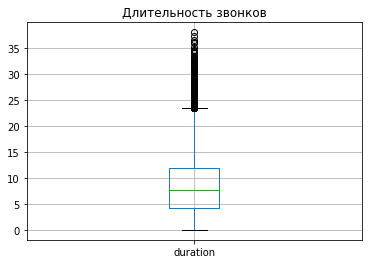

In [24]:
# получение общей информации о столбце duration
display(df_calls[df_calls['duration' ] > 0].duration.describe())
ax = df_calls[df_calls['duration' ] > 0].boxplot('duration')
ax.set_title('Длительность звонков')

Text(0.5, 1.0, 'Распределение звонков по длительности (без учета не принятых)')

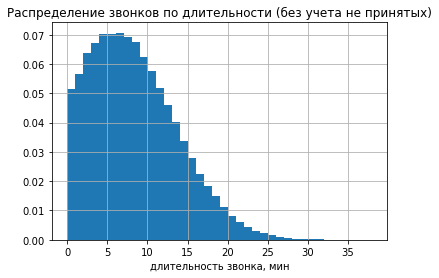

In [25]:
ax = df_calls[df_calls['duration' ] > 0]['duration'].hist(density=True, bins=38)
ax.set_xlabel('длительность звонка, мин')
ax.set_title('Распределение звонков по длительности (без учета не принятых)')

За исключением непринятых звонков, составляющих отдельную группу, длительность звонков имеет асимметричное нормальное распределение с положительной скошенностью. 
Средняя продолжительность звонка 7.7 минут, исключительно долгие звонки длятся от 23 до 38 минут.

count     492.000000
mean      331.288618
std       235.075925
min         7.000000
25%       143.750000
50%       277.500000
75%       473.250000
max      1424.000000
Name: user_id, dtype: float64

Text(0.5, 1.0, 'Количество принятых звонков на каждого клиента')

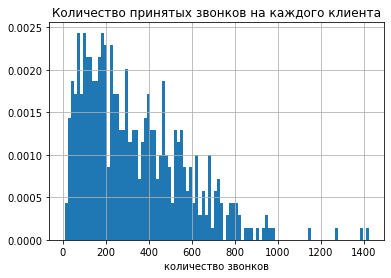

In [26]:
# группировка по клиентам, вычисление числа звонков
display(df_calls[df_calls['duration' ] > 0].groupby('user_id')['user_id'].count().describe())
ax = df_calls[df_calls['duration' ] > 0].groupby('user_id')['user_id'].count().hist(density=True, bins=100)
ax.set_xlabel('количество звонков')
ax.set_title('Количество принятых звонков на каждого клиента')

Отбрасывая непринятые звонки, мы видим, что в среднем один пользователь совершил около 300 звонков. Минимальное число звонков равно 7, максимальное 1 424.

### Сообщения

In [27]:
# запись данных из csv-файла в датафрейм   
try:
    df_messages = pd.read_csv('messages.csv')
except:
    df_messages = pd.read_csv('/datasets/messages.csv')

In [28]:
# вывод первых 10 строк таблицы с данными
df_messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [29]:
# получение общей информации о таблице
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Датасет *messages* (информация о сообщениях) содержит такие столбцы:
- *id* — уникальный номер сообщения
- *message_date* — дата сообщения
- *user_id* — идентификатор пользователя, отправившего сообщение

Датасет заполнен без пропусков, столбец message_date может потребовать преобразование в формат даты.

In [30]:
# проверка на дубликаты
df_messages.duplicated().sum()

0

Дубликатов нет.

In [31]:
# подсчет уникальных пользователей в датасете
df_messages.user_id.nunique()

426

In [32]:
# вывод периода
print('Даты отправки сообщений: от', df_messages.message_date.min(), 'до', df_messages.message_date.max())

Даты отправки сообщений: от 2018-01-02 до 2018-12-31


В течение всего года было отправлено 123 тыс. сообщений; 74 клиента этой услугой не воспользовались ни разу.

In [33]:
# подсчет количества сообщений для каждого пользователя
df_messages.groupby('user_id')['user_id'].count().describe()

count     426.000000
mean      288.816901
std       267.607552
min         1.000000
25%        85.750000
50%       215.500000
75%       414.000000
max      1463.000000
Name: user_id, dtype: float64

Text(0.5, 1.0, 'Количество сообщений на каждого клиента')

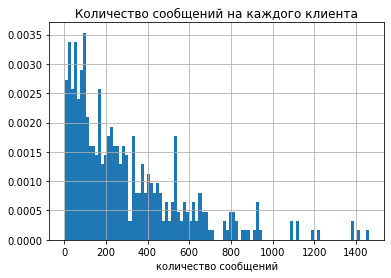

In [34]:
# построение гистограммы плотности 
ax = df_messages.groupby('user_id')['user_id'].count().hist(density=True, bins=100)
ax.set_xlabel('количество сообщений')
ax.set_title('Количество сообщений на каждого клиента')

В среднем было отправлено 215 сообщений на одного пользователя; размах значений количества сообщений от 0 до 1 463. 

### Интернет

In [35]:
# запись данных из csv-файла в датафрейм   
try:
    df_internet = pd.read_csv('internet.csv')
except:
    df_internet = pd.read_csv('/datasets/internet.csv')

In [36]:
# вывод первых 10 строк таблицы с данными
df_internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [37]:
# получение общей информации о таблице
df_internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


In [38]:
# получение общей информации о таблице
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


В датасете *internet* (информация об интернет-сессиях) есть следующие столбцы:
- *id* — уникальный номер сессии
- *mb_used* — объём потраченного за сессию интернет-трафика (в мегабайтах)
- *session_date* — дата интернет-сессии
- *user_id* — идентификатор пользователя

Столбец *Unnamed: 0*, который также находится в датасете, дублирует индекс и будет удален на следующем шаге.

Кроме того, на следующем шаге потребуется изменение формата столбца с датами интернет-сессий.

Пропусков нет.

In [39]:
# проверка
df_internet.duplicated().sum()

0

Дубликатов нет.

In [40]:
# подсчет уникальных пользователей в датасете
df_internet.user_id.nunique()

497

In [41]:
# вывод периода
print('Даты интернет-сессий: от', df_internet.session_date.min(), 'до', df_internet.session_date.max())

Даты интернет-сессий: от 2018-01-01 до 2018-12-31


В течение всего года клиенты выходили в интернет 150 тыс. раз.; данной услугой не воспользовались только 3 человека.

In [42]:
# вычисление количества интернет-сессий для каждого клиента
df_internet.groupby('user_id')['user_id'].count().describe()

count    497.000000
mean     300.595573
std      183.692830
min        8.000000
25%      155.000000
50%      284.000000
75%      424.000000
max      834.000000
Name: user_id, dtype: float64

Text(0.5, 1.0, 'Количество интернет-сессий на каждого клиента')

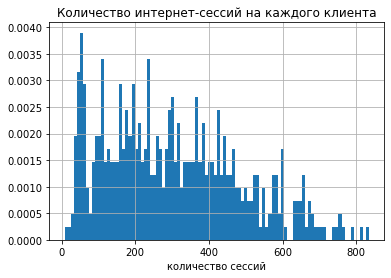

In [43]:
# построение гистограммы
ax = df_internet.groupby('user_id')['user_id'].count().hist(density=True, bins=100)
ax.set_xlabel('количество сессий')
ax.set_title('Количество интернет-сессий на каждого клиента')

В среднем один клиент подключался к интернету около 300 раз, максимум - 834 раза.

In [44]:
# вычисление объема трафика для каждого клиента
df_internet.groupby('user_id')['mb_used'].sum().describe()

count       497.000000
mean     111278.204688
std       70369.780429
min        4603.520000
25%       54460.340000
50%      101140.050000
75%      153486.320000
max      376397.380000
Name: mb_used, dtype: float64

Text(0.5, 1.0, 'Объем трафика на каждого клиента')

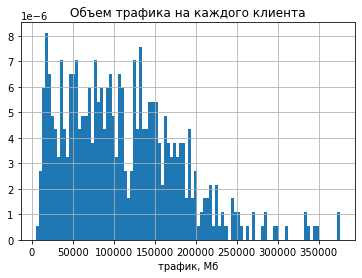

In [45]:
# построение гистограммы
ax = df_internet.groupby('user_id')['mb_used'].sum().hist(density=True, bins=100)
ax.set_xlabel('трафик, Мб')
ax.set_title('Объем трафика на каждого клиента')

В среднем за год пользователь расходует около 100 гигабайтов трафика.

Text(0.5, 1.0, 'Распределение сессий по трафику')

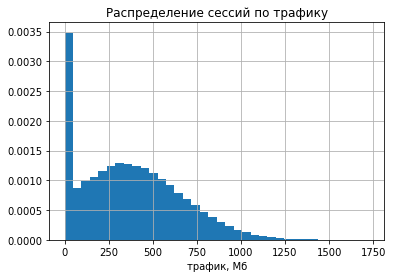

In [46]:
# построение гистограммы
ax = df_internet['mb_used'].hist(density=True, bins=36)
ax.set_xlabel('трафик, Мб')
ax.set_title('Распределение сессий по трафику')

На гистограмме распределения сессий по трафику видим красивое нормальное распределение - и большое скопление около нуля. Посмотрим поближе на этот отрезок:

Text(0.5, 1.0, 'Распределение сессий с объемом трафика меньше 100 Мб')

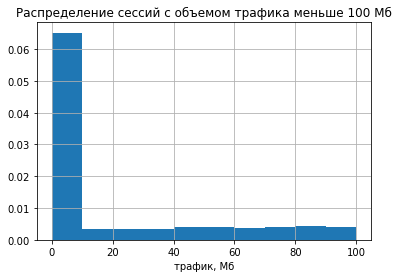

In [47]:
ax = df_internet[df_internet['mb_used'] < 100]['mb_used'].hist(density=True)
ax.set_xlabel('трафик, Мб')
ax.set_title('Распределение сессий с объемом трафика меньше 100 Мб')

In [48]:
# подсчет сессий с нулевым трафиком
df_internet[df_internet['mb_used'] == 0]['mb_used'].count()

19598

In [49]:
# вывод строк с минимальным ненулевым трафиком
df_internet[(df_internet['mb_used'] < 1) & (df_internet['mb_used'] > 0)].sort_values('mb_used').head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
15944,15944,1055_402,0.03,2018-06-15,1055
85722,85722,1291_278,0.04,2018-08-10,1291
108198,108198,1370_3,0.06,2018-07-18,1370
11027,11027,1038_76,0.07,2018-12-30,1038
11399,11399,1040_22,0.07,2018-11-23,1040
124847,124847,1421_32,0.08,2018-11-15,1421
12506,12506,1044_143,0.08,2018-11-18,1044
19101,19101,1065_246,0.08,2018-03-17,1065
102165,102165,1341_280,0.09,2018-08-29,1341
27569,27569,1096_77,0.09,2018-07-09,1096


В датасет попало почти 20 тысяч сессий с нулевым трафиком (13% от всех сессий).      
Это не могут быть очень короткие сессии, округленные до нуля, так как в датасете зафиксированы сессии объемом в несколько сотых мегабайта.         
Возможное объяснение: пользователь подключил интернет по ошибке и тут же выключил (или была проблема со связью, ничего не загрузилось, пользователь прервал соединение).     
Чтобы посмотреть, насколько аномальны такие случаи (и не были ли они, например, следствием сбоя в какой-то период), посчитаем их долю для каждого месяца.

In [50]:
# выделение строк с нулевыми сессиями в отдельный датасет, перевод даты в формат даты, добавление столбца с месяцем
no_traffic = df_internet[df_internet['mb_used'] == 0]
no_traffic['session_date'] = pd.to_datetime(no_traffic['session_date'])
no_traffic['month'] = no_traffic['session_date'].dt.month
no_traffic

C:\Users\1\AppData\Local\Temp/ipykernel_6020/3877133441.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_traffic['session_date'] = pd.to_datetime(no_traffic['session_date'])
C:\Users\1\AppData\Local\Temp/ipykernel_6020/3877133441.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_traffic['month'] = no_traffic['session_date'].dt.month


,Unnamed: 0,id,mb_used,session_date,user_id,month
11,11,1000_11,0.0,2018-08-28,1000,8
38,38,1000_38,0.0,2018-11-27,1000,11
46,46,1000_46,0.0,2018-06-30,1000,6
67,67,1000_67,0.0,2018-06-16,1000,6
72,72,1000_72,0.0,2018-06-15,1000,6
...,...,...,...,...,...,...
149380,149380,1499_141,0.0,2018-12-11,1499,12
149381,149381,1499_142,0.0,2018-11-01,1499,11
149383,149383,1499_144,0.0,2018-11-27,1499,11
149386,149386,1499_147,0.0,2018-10-21,1499,10


In [51]:
# группировка по месяцу
no_traffic_month = no_traffic.groupby('month')['id'].count().reset_index()
no_traffic_month

,month,id
0,1,151
1,2,378
2,3,623
3,4,819
4,5,1199
5,6,1401
6,7,1760
7,8,2083
8,9,2314
9,10,2642


In [52]:
# перевод даты в формат даты, добавление столбца с месяцем, группировка по месяцу
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])
df_internet['month'] = df_internet['session_date'].dt.month
all_traffic = df_internet.groupby('month')['id'].count().reset_index()
all_traffic

,month,id
0,1,1117
1,2,2641
2,3,4885
3,4,6511
4,5,9408
5,6,11057
6,7,13548
7,8,16092
8,9,17512
9,10,20009


In [53]:
# объединение таблиц, подсчет доли
traffic = no_traffic_month.merge(all_traffic,  how='left', on='month', suffixes=('_no_traffic', '_all_traffic'))
traffic['share'] = traffic['id_no_traffic'] / traffic['id_all_traffic']
traffic

,month,id_no_traffic,id_all_traffic,share
0,1,151,1117,0.135184
1,2,378,2641,0.143128
2,3,623,4885,0.127533
3,4,819,6511,0.125787
4,5,1199,9408,0.127445
5,6,1401,11057,0.126707
6,7,1760,13548,0.129908
7,8,2083,16092,0.129443
8,9,2314,17512,0.132138
9,10,2642,20009,0.132041


Доля нулевых сессий распределена равномерно по всему периоду и составляет те же примерно 13%, что и для всего массива данных - то есть это не проблема временного сбоя.   
Теперь, когда мы знаем о их существовании, нужно пересчитать количество интернет-сессий для каждого клиента.

In [54]:
# вычисление количества ненулевых интернет-сессий для каждого клиента 
df_internet[df_internet['mb_used'] > 0].groupby('user_id')['user_id'].count().describe()

count    497.000000
mean     261.162978
std      158.699133
min        8.000000
25%      130.000000
50%      239.000000
75%      362.000000
max      731.000000
Name: user_id, dtype: float64

Закономерно, что среднее, медиана и максимум уменьшились по сравнению с предыдущим результатом (рассчитанным с нулевыми сессиями).   
В среднем один клиент подключался к интернету около 250 раз, максимум - 731 раза.

Text(0.5, 1.0, 'Количество интернет-сессий на каждого клиента')

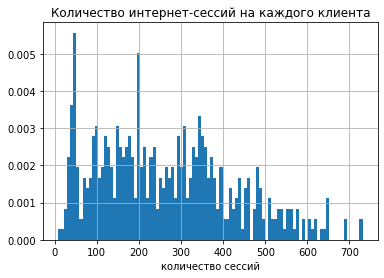

In [55]:
# построение гистограммы
ax = df_internet[df_internet['mb_used'] > 0].groupby('user_id')['user_id'].count().hist(density=True, bins=100)
ax.set_xlabel('количество сессий')
ax.set_title('Количество интернет-сессий на каждого клиента')

Наблюдаем интересные пики в районе 45 и 200 сессий.</font>

### Тарифы

In [56]:
# запись данных из csv-файла в датафрейм   
try:
    df_tariffs = pd.read_csv('tariffs.csv')
except:
    df_tariffs = pd.read_csv('/datasets/tariffs.csv')

df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица *tariffs* (информация о тарифах):
- *tariff_name* — название тарифа
- *rub_monthly_fee* — ежемесячная абонентская плата в рублях
- *minutes_included* — количество минут разговора в месяц, включённых в абонентскую плату
- *messages_included* — количество сообщений в месяц, включённых в абонентскую плату
- *mb_per_month_included* — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- *rub_per_minute* — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- *rub_per_message* — стоимость отправки сообщения сверх тарифного пакета
- *rub_per_gb* — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Преобразование форматов

Приведем столбцы с датами во всех датасетах к формату datetime.

In [57]:
# преобразование формата даты
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'])
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])

Также удалим столбец, дублирующий индекс в датасете df_internet:

In [58]:
# удаление столбца 
df_internet = df_internet.drop('Unnamed: 0', axis=1)

### Вывод

В ходе обзора датасетов мы убедились, что предоставленные данные описывают поведение 500 пользователей за 2018 год.
Значения записаны в соответствующих характеру данных форматах, нам потребовалось только перевести даты в формат datetime. 
Пропущенных значений нет; в столбце churn_date пропуск означает, что тариф ещё действовал на момент выгрузки выборки.
Аномальных значений не обнаружено.
В одном из датасетов был удален столбец, дублирующий индекс.

Высокое качество и чистота данных позволили нам сразу вывести основные характеристики клиентов и того, как они пользуются услугами "Мегалайн".

Из 500 клиентов нашей выборки подавляющее большинство, 70%, пользуется тарифом "Смарт" и 30% - тарифом "Ультра". Все они подключились в течение 2018 года, длительность использования тарифа таким образом может разниться от 1 до 365 дней. Часть клиентов в этом же году отказались от услуг компании: для тарифа "Смарт" их доля составила 6,5%, для тарифа "Ультра" - 15,5%.

Возраст клиентов - от 18 до 75 лет, с незначительным преобладанием людей в возрасте 41-43 лет. Выборка охватывает пользователей из 76 городов, пятую часть составляют москвичи, на втором месте Санкт-Петербург.

Всего в наших датасетах зафиксированы данные о 203 тыс. звонков, 123 тыс. сообщений и 150 тыс. интернет-сессий. Этими услугами в течение года пользовались практически все 500 клиентов, за редким исключениями: 3 клиента не выходили в интернет, 8 клиентов никуда не звонили, 74 клиента не посылали сообщений.

Средняя продолжительность звонка 7,7 минут, исключительно долгие звонки длятся от 23 до 38 минут. В среднем, один пользователь совершил около 300 звонков. Минимальное число звонков равно 7, максимальное 1 424. Примерно пятая часть звонков - пропущенные.

В среднем на одного пользователя было отправлено 215 сообщений (размах количества сообщений составляет от 0 до 1 463). Среднее количество подключений к интернету - около 250 раз, максимум - 731 раза. В среднем за год пользователь расходует около 100 гигабайтов трафика.

## Помесячные показатели для каждого пользователя

### Звонки
Посчитаем для каждого пользователя в датасете df_calls количество сделанных звонков и израсходованных минут разговора по месяцам.
Для этого добавим столбец с номером месяца.

In [59]:
# добавление столбца с указанием месяца
df_calls['month'] = df_calls['call_date'].dt.month

«Мегалайн» всегда округляет секунды до минут, и каждый звонок округляется отдельно. Поэтому мы добавим дополнительный столбец, в котором будет записана продолжительность звонков (округленная до минут) для расчета выручки.

In [60]:
# добавление столбца с округлением к большему
# df_calls['duration_roundup'] = df_calls['duration'].apply(np.ceil)

# новый код
df_calls['duration_roundup'] = np.ceil(df_calls['duration'])

# изменение формата
df_calls['duration_roundup'] = df_calls['duration_roundup'].astype('int')
df_calls

,id,call_date,duration,user_id,month,duration_roundup
0,1000_0,2018-07-25,0.00,1000,7,0
1,1000_1,2018-08-17,0.00,1000,8,0
2,1000_2,2018-06-11,2.85,1000,6,3
3,1000_3,2018-09-21,13.80,1000,9,14
4,1000_4,2018-12-15,5.18,1000,12,6
...,...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,12,1
202603,1499_216,2018-10-18,18.83,1499,10,19
202604,1499_217,2018-11-10,10.81,1499,11,11
202605,1499_218,2018-10-06,4.27,1499,10,5


Рассчитаем количество звонков для каждого пользователя за месяц, а также их общую длительность - как фактическую, так и округленную, на основе которой будет рассчитана выручка. 

В подсчет количества не будем включать пропущенные звонки, так как они не влияют на выручку и ничего не говорят о пользователе.

In [61]:
# суммирование минут и подсчет звонков по пользователям; создание датафрейма
df_calls_groupby = df_calls[df_calls['duration'] > 0].groupby(['user_id', 'month']).agg(
    {'duration': ['count', 'sum'], 'duration_roundup': 'sum'}).reset_index()

# переименование столбцов
df_calls_groupby.columns = ['user_id', 'month', 'calls_count', 'calls_fact_duration', 'calls_duration']
df_calls_groupby

,user_id,month,calls_count,calls_fact_duration,calls_duration
0,1000,5,17,150.06,159
1,1000,6,28,158.90,172
2,1000,7,41,318.80,340
3,1000,8,42,389.87,408
4,1000,9,46,440.14,466
...,...,...,...,...,...
3163,1498,10,30,232.63,247
3164,1499,9,8,64.65,70
3165,1499,10,44,429.91,449
3166,1499,11,62,576.50,612


### Сообщения

Найдем для каждого пользователя в датасете df_messages количество отправленных сообщений по месяцам.

In [62]:
# добавление столбца с указанием месяца
df_messages['month'] = df_messages['message_date'].dt.month

In [63]:
# подсчет сообщений по пользователям; добавление в датафрейм
df_messages_groupby = df_messages.groupby(['user_id', 'month']).agg({'id': 'count'}).reset_index()

# переименование столбцов
df_messages_groupby.columns = ['user_id', 'month', 'messages_count']
df_messages_groupby

,user_id,month,messages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


### Интернет

Вычислим для каждого пользователя в датасете df_internet объем израсходованного интернет-трафика по месяцам.

In [64]:
# добавление столбца с указанием месяца
df_internet['month'] = df_internet['session_date'].dt.month

In [65]:
# подсчет трафика интернет-сессий по пользователям; добавление в датафрейм
df_internet_groupby = df_internet.groupby(['user_id', 'month']).agg({'mb_used': 'sum'}).reset_index()
df_internet_groupby

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
...,...,...,...
3198,1498,10,20579.36
3199,1499,9,1845.75
3200,1499,10,17788.51
3201,1499,11,17963.31


При полсчете веб-трафика общая сумма за месяц округляется в большую сторону. Добавим столбец для расчета выручки с округлением.

In [66]:
# добавление столбца с расчетом в гигабайтах
df_internet_groupby['gb_used'] = np.ceil(df_internet_groupby['mb_used'] / 1024)
df_internet_groupby['gb_used'] = df_internet_groupby['gb_used'].astype('int')

### Выручка

Выделим id пользователя и название его тарифа в новый датасет.

In [67]:
# выделение id пользователя и названия его тарифа в отдельный датафрейм
users_t = df_users[['user_id', 'tariff']]
users_t.columns=['user_id', 'tariff_name']

Теперь объединим данные об использованных минутах, сообщениях и мегабайтах и присоединим их к только что созданной таблице.

In [68]:
# объединение датафреймов "звонки" и "сообщения"
calls_msg_mb = df_calls_groupby.merge(df_messages_groupby, on=['user_id', 'month'], how='outer')
calls_msg_mb

,user_id,month,calls_count,calls_fact_duration,calls_duration,messages_count
0,1000,5,17.0,150.06,159.0,22.0
1,1000,6,28.0,158.90,172.0,60.0
2,1000,7,41.0,318.80,340.0,75.0
3,1000,8,42.0,389.87,408.0,81.0
4,1000,9,46.0,440.14,466.0,57.0
...,...,...,...,...,...,...
3207,1489,8,NaN,NaN,NaN,17.0
3208,1489,9,NaN,NaN,NaN,32.0
3209,1489,10,NaN,NaN,NaN,21.0
3210,1489,11,NaN,NaN,NaN,20.0


In [69]:
# добавление датафрейма "интернет"
calls_msg_mb = calls_msg_mb.merge(df_internet_groupby, on=['user_id', 'month'], how='outer')
calls_msg_mb

,user_id,month,calls_count,calls_fact_duration,calls_duration,messages_count,mb_used,gb_used
0,1000,5,17.0,150.06,159.0,22.0,2253.49,3.0
1,1000,6,28.0,158.90,172.0,60.0,23233.77,23.0
2,1000,7,41.0,318.80,340.0,75.0,14003.64,14.0
3,1000,8,42.0,389.87,408.0,81.0,14055.93,14.0
4,1000,9,46.0,440.14,466.0,57.0,14568.91,15.0
...,...,...,...,...,...,...,...,...
3209,1489,10,NaN,NaN,NaN,21.0,19559.44,20.0
3210,1489,11,NaN,NaN,NaN,20.0,17491.56,18.0
3211,1489,12,NaN,NaN,NaN,35.0,17322.51,17.0
3212,1240,2,NaN,NaN,NaN,NaN,959.51,1.0


In [70]:
# объединение всех данных
users_fact = calls_msg_mb.merge(users_t, on='user_id', how='outer')
users_fact

,user_id,month,calls_count,calls_fact_duration,calls_duration,messages_count,mb_used,gb_used,tariff_name
0,1000,5.0,17.0,150.06,159.0,22.0,2253.49,3.0,ultra
1,1000,6.0,28.0,158.90,172.0,60.0,23233.77,23.0,ultra
2,1000,7.0,41.0,318.80,340.0,75.0,14003.64,14.0,ultra
3,1000,8.0,42.0,389.87,408.0,81.0,14055.93,14.0,ultra
4,1000,9.0,46.0,440.14,466.0,57.0,14568.91,15.0,ultra
...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,NaN,NaN,NaN,21.0,19559.44,20.0,smart
3212,1489,11.0,NaN,NaN,NaN,20.0,17491.56,18.0,smart
3213,1489,12.0,NaN,NaN,NaN,35.0,17322.51,17.0,smart
3214,1128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ultra


Как мы видим, часть данных в получившемся датафрейме пропущена: в какие-то периоды определенные пользователи могли не пользоваться теми или иными услугами. Заполним пропуски нулем.

In [71]:
# заполнение пропусков нулем
users_fact = users_fact.fillna(0)

Приступим к подсчету помесячной выручки на каждого пользователя. Она составит сумму абонентской платы и платы за превышение  лимита звонков, сообщений и интернет-трафика.

In [72]:
# создание словаря с условиями тарифов
tariffs_dict = df_tariffs.to_dict()

# определение функции для расчета выручки
def revenue(row):
    """
    Возвращает сумму помесячной оплаты и оплаты за перерасход (превышение лимита * плата за единицу)
    """
    # определение условий тарифа (в словаре 0 - смарт, 1 - ультра)
    if row['tariff_name'] == 'smart':
        i = 0 
    else:
        i = 1
    
    rvn = tariffs_dict['rub_monthly_fee'][i]  # ежемесячная плата
    
    # перерасход
    if row['calls_duration'] > tariffs_dict['minutes_included'][i]:
        rvn += (row['calls_duration'] - tariffs_dict['minutes_included'][i]) * tariffs_dict['rub_per_minute'][i]
    if row['messages_count'] > tariffs_dict['messages_included'][i]:
        rvn += (row['messages_count'] - tariffs_dict['messages_included'][i]) * tariffs_dict['rub_per_message'][i]
    if row['gb_used'] > (tariffs_dict['mb_per_month_included'][i] / 1024):
        rvn += (row['gb_used'] - (tariffs_dict['mb_per_month_included'][i] / 1024)) * tariffs_dict['rub_per_gb'][i] 
        
    return rvn    

In [73]:
# добавление столбца с расчетом выручки
users_fact['revenue'] = users_fact.apply(revenue, axis=1)
users_fact

,user_id,month,calls_count,calls_fact_duration,calls_duration,messages_count,mb_used,gb_used,tariff_name,revenue
0,1000,5.0,17.0,150.06,159.0,22.0,2253.49,3.0,ultra,1950.0
1,1000,6.0,28.0,158.90,172.0,60.0,23233.77,23.0,ultra,1950.0
2,1000,7.0,41.0,318.80,340.0,75.0,14003.64,14.0,ultra,1950.0
3,1000,8.0,42.0,389.87,408.0,81.0,14055.93,14.0,ultra,1950.0
4,1000,9.0,46.0,440.14,466.0,57.0,14568.91,15.0,ultra,1950.0
...,...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,0.0,0.00,0.0,21.0,19559.44,20.0,smart,1550.0
3212,1489,11.0,0.0,0.00,0.0,20.0,17491.56,18.0,smart,1150.0
3213,1489,12.0,0.0,0.00,0.0,35.0,17322.51,17.0,smart,950.0
3214,1128,0.0,0.0,0.00,0.0,0.0,0.00,0.0,ultra,1950.0


В конце таблицы видим двух клиентов, 1128 и 1371, у которых все показатели расхода равны нулю. Если абонентская плата не списывается сразу при подключении, то эти два клиента не должны быть включены в расчет выручки. 
А поскольку они не пользовались никакими услугами, то могут быть удалены из датасета.

Проверим, есть ли еще такие случаи, когда клиент в течение месяца ничем не пользовался: 

In [74]:
# добавление столбца с суммированием всех расходов 
users_fact['all_services'] = users_fact['calls_fact_duration'] + users_fact['messages_count'] + users_fact['mb_used'] 
users_fact[users_fact['all_services'] == 0]

,user_id,month,calls_count,calls_fact_duration,calls_duration,messages_count,mb_used,gb_used,tariff_name,revenue,all_services
3214,1128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,1950.0,0.0
3215,1371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,smart,550.0,0.0


Найдены только те же самые два клиента. Удаляем из датасета:

In [75]:
# удаление строк
users_fact = users_fact.drop([3214, 3215])

### Вывод

Мы рассчитали помесячные показатели для каждого пользователя: количество и длительность звонков, объем интернет-трафика, количество сообщений. Также мы получили данные по ежемесячным оплатам за весь период.

## Анализ тарифов по показателям 

Разделим датасет на две части, тариф "Смарт" и "Ультра", выведем базовые характеристики выручки по тарифам и определим вспомогательные функции для последующего анализа.

In [76]:
# формирование датафреймов по условию
smart = users_fact[users_fact['tariff_name'] == 'smart']
ultra = users_fact[users_fact['tariff_name'] == 'ultra']

In [77]:
# подсчет суммы выручки по тарифам
print('Общая сумма выручки:')
print('"Смарт":', round(smart['revenue'].sum()/1000000, 2), 'млн. руб.')
print('"Ультра":', round(ultra['revenue'].sum()/1000000, 2), 'млн. руб.')
print()
print('Средний чек (выручка на 1 пользователя в месяц):')
print('"Смарт":', round(smart['revenue'].sum()/len(smart), 2), 'руб.')
print('"Ультра":', round(ultra['revenue'].sum()/len(ultra), 2), 'руб.')

Общая сумма выручки:
"Смарт": 2.88 млн. руб.
"Ультра": 2.04 млн. руб.

Средний чек (выручка на 1 пользователя в месяц):
"Смарт": 1289.97 руб.
"Ультра": 2070.15 руб.


In [78]:
# подсчет длительности пользования тарифом
print('Средняя длительность пользования тарифом (в месяцах):')
print('\t','"Смарт":', round(smart.groupby('user_id')['user_id'].count().mean(), 1), '(среднее),',
      smart.groupby('user_id')['user_id'].count().median(),'(медиана)')
print('\t','"Ультра":', round(ultra.groupby('user_id')['user_id'].count().mean(), 1), '(среднее),',
      ultra.groupby('user_id')['user_id'].count().median(),'(медиана)')

Средняя длительность пользования тарифом (в месяцах):
	 "Смарт": 6.4 (среднее), 6.0 (медиана)
	 "Ультра": 6.7 (среднее), 7.0 (медиана)


In [79]:
# определение функции для подсчета характеристик
def mean_var_std(parameter):
    """
    Возвращает датафрейм с основными статистиками 
    """
    tariffs = [smart, ultra]
    data = []
    for tariff in tariffs:
        row = []
        row.append(round(tariff[parameter].median(), 2))   # медиана
        row.append(round(tariff[parameter].mean(), 2))   # среднее
        row.append(round(np.var(tariff[parameter], ddof=1), 2))   # дисперсия
        row.append(round(np.std(tariff[parameter], ddof=1), 2))   # стандартное отклонение
        data.append(row)   # добавление списка
        
    # добавление названий тарифов в начало каждой строки
    data[0].insert(0, 'smart')
    data[1].insert(0, 'ultra')
    
    # формирование датафрейма 
    return pd.DataFrame(data=data, columns=['tariff', 'median', 'mean', 'var', 'std'])

In [80]:
# определение функции для построения плотностной гистограммы
def density_hist(parameter, bins=100):
    """
    Строит гистограмму плотности
    """
    plt.figure(figsize=(10,5))
    plt.hist(smart[parameter], density=True, color = '#041E42', label='smart', bins=bins)
    plt.hist(ultra[parameter], density=True, color = '#C8102E', histtype='step', linewidth=3, label='ultra', bins=bins)
    plt.legend()

In [81]:
# определение функции для построения диаграммы размаха
def boxplot_hist(parameter):
    sns.boxplot(y=users_fact['tariff_name'], x=users_fact[parameter],
            palette={'smart': '#05295A', 'ultra': '#C8102E'},
            orient='h')

### Звонки

In [82]:
# вывод характеристик для каждой выборки
mean_var_std('calls_fact_duration')

,tariff,median,mean,var,std
0,smart,397.98,394.43,32386.4,179.96
1,ultra,488.10,497.07,89942.5,299.90


Text(0.5, 1.0, 'Длительность звонков по тарифам')

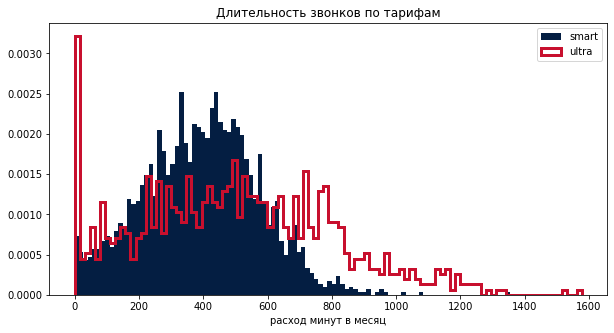

In [83]:
# построение плотностной гистограммы 
density_hist('calls_fact_duration')
plt.xlabel('расход минут в месяц')
plt.title('Длительность звонков по тарифам')

Text(0.5, 1.0, 'Длительность звонков по тарифам')

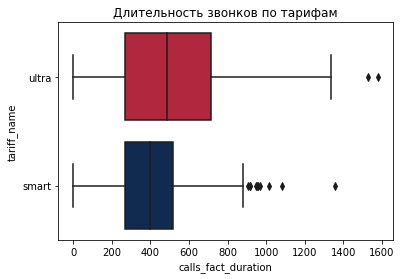

In [84]:
# построение гистограммы размаха
boxplot_hist('calls_fact_duration')
plt.title('Длительность звонков по тарифам')

In [85]:
# доля пользователей "смарт" с превышением лимита
smart[smart['calls_duration'] > 500]['calls_duration'].count() / len(smart)

0.3382682817406909

In [86]:
# подсчет выручки ("смарт", длительность больше лимита)

smart['calls_over'] = smart['calls_duration'] - 500
smart['calls_over'] = smart['calls_over'].where(smart['calls_over'] > 0, 0)
smart['calls_over'].sum() * 3 

C:\Users\1\AppData\Local\Temp/ipykernel_6020/2638153937.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smart['calls_over'] = smart['calls_duration'] - 500
C:\Users\1\AppData\Local\Temp/ipykernel_6020/2638153937.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smart['calls_over'] = smart['calls_over'].where(smart['calls_over'] > 0, 0)


278217.0

Распределение длительности для тарифа "**Смарт**" близко к нормальному с положительной скошенностью.

Пользователи тарифа "Смарт" в среднем используют 400 минут разговора в месяц при бесплатном лимите в 500 минут. 

При этом значительная часть пользователей выходит за рамки тарифа: в нашем датасете это 34% записей (где каждая запись - это показатель одного пользователя за месяц). Несколько клиентов превысили лимит в два раза.
В сумме превышение лимита по минутам принесло 278 тыс. руб. (9,6% всей выручки по тарифу "Смарт").

In [87]:
# количество пользователей "смарт", не воспользовавшихся звонками
smart[smart['calls_fact_duration'] == 0]['user_id'].count()

8

In [88]:
# количество пользователей "ультра", не воспользовавшихся звонками
ultra[ultra['calls_fact_duration'] == 0]['user_id'].count()

38

Пользователи тарифа "**Ультра**" в среднем тратят больше минут, чем на тарифе "Смарт", но при этом никогда не выходят за рамки тарифного плана. 

Размах значений шире, но не превышает 1600 минут (при лимите в 3000). Основная масса значений расположена на отрезке между 200 и 700, есть длинный хвост в положительном направлении. 

Любопытно, что среди пользователей "Ультра" в 4 раза больше клиентов, за месяц ни разу не воспользовавшихся звонками (38 против 8 на тарифе "Смарт").

### Сообщения

In [89]:
# вывод характеристик для каждой выборки
mean_var_std('messages_count')

,tariff,median,mean,var,std
0,smart,28.0,33.38,796.81,28.23
1,ultra,38.0,49.36,2285.27,47.80


Text(0.5, 1.0, 'Количество сообщений по тарифам')

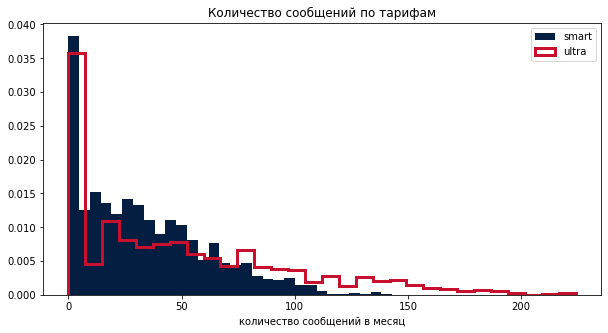

In [90]:
# построение плотностной гистограммы 
density_hist('messages_count', 30)
plt.xlabel('количество сообщений в месяц')
plt.title('Количество сообщений по тарифам')

Text(0.5, 1.0, 'Количество сообщений по тарифам')

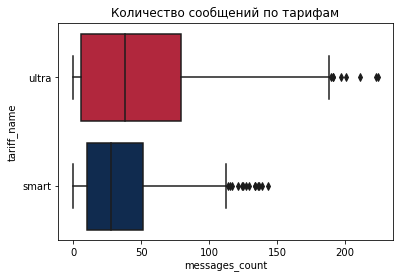

In [91]:
# построение гистограммы размаха
boxplot_hist('messages_count')
plt.title('Количество сообщений по тарифам')

In [92]:
# доля пользователей "смарт", не воспользовавшихся сообщениями
smart[smart['messages_count'] == 0]['user_id'].count() / len(smart)

0.13772992373261553

In [93]:
# доля пользователей "ультра", не воспользовавшихся сообщениями
ultra[ultra['messages_count'] == 0]['user_id'].count() / len(ultra)

0.19289340101522842

In [94]:
# выручка при превышении лимита ("смарт")
smart['messages_over'] = smart['messages_count'] - 50
smart['messages_over'] = smart['messages_over'].where(smart['messages_over'] > 0, 0)
smart['messages_over'].sum() * 3

C:\Users\1\AppData\Local\Temp/ipykernel_6020/2143472554.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smart['messages_over'] = smart['messages_count'] - 50
C:\Users\1\AppData\Local\Temp/ipykernel_6020/2143472554.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smart['messages_over'] = smart['messages_over'].where(smart['messages_over'] > 0, 0)


38784.0

На обоих графиках распределений количества сообщений мы видим пики значений, расположенные в начале оси. 14% ежемесячных показателей для тарифа "Смарт" и 19% для тарифа "Ультра" равны нулю. 

Среднее количество сообщений для тарифа "**Смарт**" близко 30. Граница 75%-ного квартиля проходит примерно по лимиту в 50 сообщений, и оставшиеся 25% значений превышают лимит и доходят до максимума в 143 сообщения в месяц. Выручка за сообщения, отправленные после превышения лимита составила 39 тыс. руб.

По сравнению со "Смартом", у тарифа "**Ультра**" межквартильный размах шире (причем как вправо, так и, в гораздо меньшей степени, влево), медианное значение больше (38 сообщений). График более плавно уходит вправо.

### Интернет

In [95]:
# вывод характеристик для каждой выборки
mean_var_std('mb_used')

,tariff,median,mean,var,std
0,smart,16506.84,16208.39,3.446250e+07,5870.48
1,ultra,19308.01,19468.81,1.017510e+08,10087.17


Text(0.5, 1.0, 'Расход трафика по тарифам')

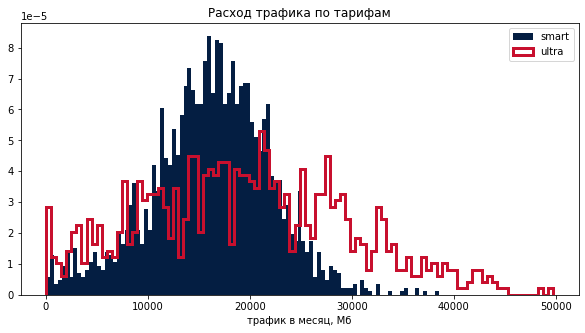

In [96]:
# построение плотностной гистограммы 
density_hist('mb_used')
plt.xlabel('трафик в месяц, Мб')
plt.title('Расход трафика по тарифам')

Text(0.5, 1.0, 'Расход трафика по тарифам')

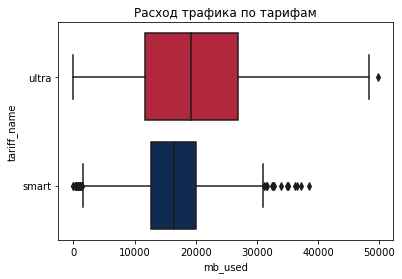

In [97]:
# построение гистограммы размаха
boxplot_hist('mb_used')
plt.title('Расход трафика по тарифам')

In [98]:
# подсчет записей без интернет-сессий на тарифе "ультра"
ultra[ultra['mb_used'] == 0]['mb_used'].count()

11

In [99]:
# выручка при превышении лимита ("смарт")
smart['gb_over'] = smart['gb_used'] - 15
smart['gb_over'] = smart['gb_over'].where(smart['gb_over'] > 0, 0)
smart['gb_over'].sum() * 200

C:\Users\1\AppData\Local\Temp/ipykernel_6020/1207233189.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smart['gb_over'] = smart['gb_used'] - 15
C:\Users\1\AppData\Local\Temp/ipykernel_6020/1207233189.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smart['gb_over'] = smart['gb_over'].where(smart['gb_over'] > 0, 0)


1332400.0

In [100]:
# выручка при превышении лимита ("ультра")
ultra['gb_over'] = ultra['gb_used'] - 30
ultra['gb_over'] = ultra['gb_over'].where(ultra['gb_over'] > 0, 0)
ultra['gb_over'].sum() * 150

C:\Users\1\AppData\Local\Temp/ipykernel_6020/677152878.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ultra['gb_over'] = ultra['gb_used'] - 30
C:\Users\1\AppData\Local\Temp/ipykernel_6020/677152878.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ultra['gb_over'] = ultra['gb_over'].where(ultra['gb_over'] > 0, 0)


118350.0

На графике использования интернета на тарифе "**Смарт**" мы наблюдаем нормальное, довольно симметричное распределение с пиком в районе 17 гигабайт. Таким образом, это единственный из трех показателей, медиана которого расположена за тарифным лимитом (который равен 15 Гб). Максимальные значения доходят почти до 40 Гб. Выручка за трафик сверх лимита составляет 1,3 млн руб. (46% от всей выручки по тарифу).


Медиана тарифа "**Ультра**" расположена правее, на отметке 18,8 Гб., межквартильный размах шире (доходит примерно до 27 Гб). Распределение очень условно можно назвать нормальным. Есть небольшой пик в начале оси: это 11 записей без расхода интернета за месяц. 

Часть значений выходят за тарифные рамки в 30 Гб - и они настолько частотны, что не являются выбросами. Максимальное значение приближается к 50 Гб. Выручка за сверхлимитное использование интернета равна 118 тыс. руб. (6% от суммы по тарифу).

### Выручка

Теперь подсчитаем, сколько за весь период было получено от 1 клиента и рассмотрим динамику по месяцам. 

Медиана выручки на одного пользователя "Смарт" за весь период: 7259.5
Медиана выручки на одного пользователя "Ультра" за весь период: 13725.0


Text(0.5, 0, 'выручка на 1 клиента, руб.')

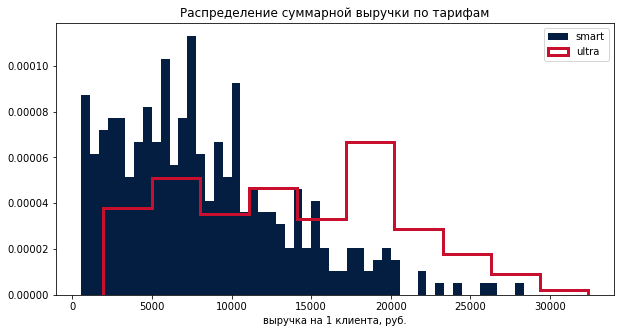

In [101]:
# новый код

# вывод медианных значений
print('Медиана выручки на одного пользователя "Смарт" за весь период:', smart.groupby('user_id')['revenue'].sum().median())
print('Медиана выручки на одного пользователя "Ультра" за весь период:', ultra.groupby('user_id')['revenue'].sum().median())

# построение гистограммы плотности
plt.figure(figsize=(10,5))
plt.hist(smart.groupby('user_id')['revenue'].sum(), density=True, color = '#041E42', label='smart', bins=50)
plt.hist(ultra.groupby('user_id')['revenue'].sum(), density=True, color = '#C8102E', histtype='step', linewidth=3, label='ultra')
plt.legend()
plt.title('Распределение суммарной выручки по тарифам')
plt.xlabel('выручка на 1 клиента, руб.')

Учитывая то, что абонентская плата на тарифе "Ультра" выше, а средние сроки пользования услугами на обоих тарифах примерно равны, логично, что медиана выручки на 1 клиента за 2018 год для тарифа "Ультра" больше, чем для тарифа "Смарт".

Но при этом, хотя ежемесячная плата "Ультра" больше в 3,5 раза, медиана тарифа "Ультра" больше медианы "Смарт" чуть меньше, чем в 2 раза. Что говорит о том, что пользователи "Смарт" чаще выходят за рамки тарифных лимитов. Это же мы видим при рассмотрении основных характеристик выборок:

In [102]:
# вывод характеристик для каждой выборки
mean_var_std('revenue')

,tariff,median,mean,var,std
0,smart,1023.0,1289.97,669785.71,818.40
1,ultra,1950.0,2070.15,141516.75,376.19


Медиана месячной выручки на 1 клиента для тарифа "Ультра" равна ежемесячной плате по тарифу, среднее отличается не намного: оно больше медианы на 6%.

В это же время медиана и среднее для тарифа "Смарт" значительно больше ежемесячной платы. Также обращает на себя внимание высокое значение стандартного отклонения.

Text(0.5, 1.0, 'Распределение ежемесячной выручки по тарифам')

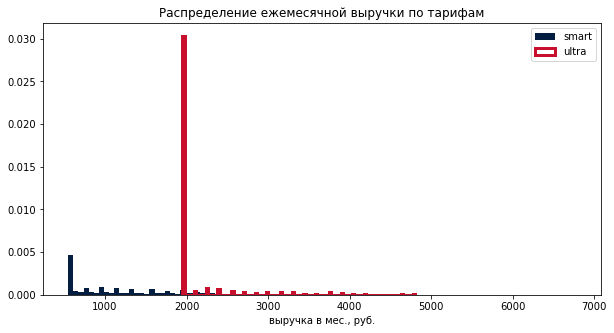

In [103]:
# построение плотностной гистограммы 
density_hist('revenue')
plt.xlabel('выручка в мес., руб.')
plt.title('Распределение ежемесячной выручки по тарифам')

Логично, что самое частотное значение выручки будет равно абонентской плате по данному тарифу. 

In [104]:
print('Доля пользователей тарифа "Ультра", заплативших только абонентскую плату:', 
      round(ultra[ultra['revenue'] == 1950]['revenue'].count() / len(ultra), 2))
print('Доля пользователей тарифа "Ультра", превысивших лимиты:', 
      round(ultra[ultra['revenue'] > 1950]['revenue'].count() / len(ultra), 2))
print('Доля пользователей тарифа "Смарт", заплативших только абонентскую плату:', 
      round(smart[smart['revenue'] == 550]['revenue'].count() / len(smart), 2))
print('Доля пользователей тарифа "Смарт", превысивших лимиты:', 
      round(smart[smart['revenue'] > 550]['revenue'].count() / len(smart), 2))

Доля пользователей тарифа "Ультра", заплативших только абонентскую плату: 0.86
Доля пользователей тарифа "Ультра", превысивших лимиты: 0.14
Доля пользователей тарифа "Смарт", заплативших только абонентскую плату: 0.25
Доля пользователей тарифа "Смарт", превысивших лимиты: 0.75


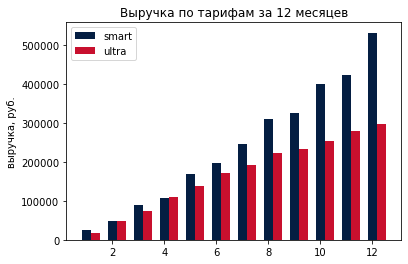

In [105]:
# построение графика по месяцам
x = np.arange(1, 13)   
width = 0.35  
plt.bar(x, smart.groupby('month')['revenue'].sum(), width, color = '#041E42', label='smart')
plt.bar(x + width, ultra.groupby('month')['revenue'].sum(), width, color = '#C8102E', label='ultra')

plt.ylabel('выручка, руб.')
plt.title('Выручка по тарифам за 12 месяцев')

plt.legend(loc='best')
plt.show()

График показывает рост выручки по обоим тарифам, причем рост выручки тарифа "Смарт" опережает тариф "Ультра". Только для двух месяцев в первом квартале (февраля и апреля) были зафиксированы примерно одинаковые показатели выручки для обоих тарифов.

Посчитаем прирост от месяца к месяцу для каждого тарифа.

In [106]:
# суммирование помесячной выручки
smart_revenue_month = smart.groupby('month')['revenue'].sum().reset_index()
ultra_revenue_month = ultra.groupby('month')['revenue'].sum().reset_index()

In [107]:
# вычисление ежемесячного прироста
growth = pd.DataFrame(index=range(2,13))
growth['ultra'] = [round(ultra_revenue_month.loc[i, 'revenue']/ultra_revenue_month.loc[i-1, 'revenue'] - 1, 2) 
                   for i in range(1,12)]
growth['smart'] = [round(smart_revenue_month.loc[i, 'revenue']/smart_revenue_month.loc[i-1, 'revenue'] - 1, 2) 
                   for i in range(1,12)]
growth = growth.transpose()
growth

,2,3,4,5,6,7,8,9,10,11,12
ultra,1.70,0.57,0.48,0.25,0.24,0.13,0.16,0.04,0.09,0.10,0.06
smart,0.96,0.87,0.20,0.57,0.17,0.25,0.26,0.05,0.23,0.06,0.25


Text(0.5, 1.0, 'Ежемесячный прирост выручки по месяцам')

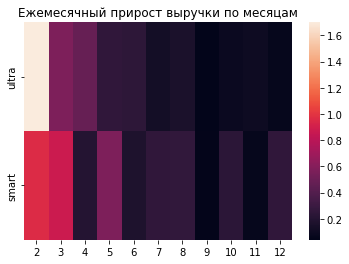

In [108]:
# построение тепловой карты
ax = sns.heatmap(growth)
plt.title('Ежемесячный прирост выручки по месяцам')

Хотя выручка по обоим тарифам растет, темп роста во второй половине года заметно снизился по сравнению с началом года - особенно для тарифа "Ультра".

Таким образом, в масштабе нашего датасета мы видим, что тариф "Ультра" приносит больше дохода по основным показателям:
- средняя выручка на 1 пользователя в месяц больше в 1,6 раз;
- медиана выручки на 1 пользователя за весь период больше в 1,9 раз.

Но при этом общая сумма выручки за весь период больше по тарифу "Смарт" (превышает общую выручку "Ультра" на 41%). Что объясняется большей популярностью этого тарифа: к нему подключено 70% пользователей.

### Вывод

Пользователи тарифа "Ультра" по сравнению с пользователями тарифа "Смарт" тратят больше времени на звонки, отправляют больше сообщений и загружают больше интернет-трафика. Медиана тарифа "Ультра" по каждому из этих показателей смещена вправо по сравнению с медианой тарифа "Смарт", межквартильные размахи шире.

При этом каждый месяц у пользователей тарифа "Ультра" остается большой запас неиспользованных минут (максимальное значение в датасете меньше лимита почти в 2 раза) и еще больший запас сообщений (максимум в датасете меньше лимита в 4 раза). Единственный показатель, где мы обнаружили перерасход - это использование интернета. 13% помесячных показателей трафика превышают тарифный лимит в 30 Гб. 

По условиям тарифа "Смарт" пользователи получают гораздо меньший объем бесплатных услуг и гораздо чаще, по сравнению с другим тарифом, эти лимиты превышают. Так, за пределы лимита по длительности звонков выходят 34% записей о помесячном использовании минут (что приносит 278 тыс. руб. выручки (9,6% всей выручки по тарифу "Смарт"); 25% превышают лимит по количеству сообщений. Значительнее всего перерасход интернет-трафика: средний показатель здесь больше тарифного плана. Выручка за трафик сверх лимита составляет 1,3 млн руб. (46% от всей выручки по тарифу).

## Проверка гипотез

### Средние по тарифам

Выше мы приводили показатели выручки по тарифам:
- Общая сумма выручки: "Смарт": 2.88 млн. руб.; "Ультра": 2.04 млн. руб.
- Средний чек (выручка на 1 пользователя в месяц): "Смарт": 1289.64 руб.; "Ультра": 2070.03 руб.

Мы видим, что среднее по выручкам различается, но поскольку наши расчеты произведены на данных выборок, а не генеральных совокупностей, этого пока не достаточно, чтобы говорить о существующем различии. 

Применим t-тест для проверки. Пользователи тарифов "Ультра" и "Смарт" - две независимые совокупности, используем метод ttest_ind. Поскольку выборки отличаются по размеру укажем equal_var равным False.

Нулевая гипотеза $H_{0}$ формулируется о равенстве средних. Наша нулевая гипотеза состоит в том, что средние выручки пользователей тарифов "Ультра" и "Смарт" равны. 

Соответственно, альтернативная гипотеза заключается в том, что средние различаются.

In [109]:
# формирование Series 
sample_1 = smart['revenue']
sample_2 = ultra['revenue']

In [110]:
# критический уровень статистической значимости
alpha = .05 

# t-тест 
results = st.ttest_ind(sample_1, sample_2, equal_var=False)

print('p-значение: ', results.pvalue) 

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  4.2606313931076085e-250
Отвергаем нулевую гипотезу


Как мы видим, получившееся p-значение значительно меньше критического уровня значимости, следовательно нулевая гипотеза о равенстве средних, скорее всего, не верна.

В соответствии с результатом t-теста средние, посчитанные на наших выборках, значительно отличаются.

### Москва и регионы

Проверим, является ли отличие средней выручки пользователей из Москвы от выручки пользователей из других регионов статистически значимым.

Нулевая гипотеза $H_{0}$ состоит в том, что средние этих совокупностей равны. Альтернативная гипотеза: средние различаются.

Поскольку здесь мы опять имеем дело с разноразмерными выборками из двух независимых совокупностей, применим метод scipy.stats.ttest_ind() с equal_var равным False.

In [111]:
# выделение связки пользователь-город в отдельный датафрейм
users_city = df_users[['user_id', 'city']]

In [112]:
# объединение датафреймов
users_fact = users_fact.merge(users_city, on='user_id', how='left')
users_fact

,user_id,month,calls_count,calls_fact_duration,calls_duration,messages_count,mb_used,gb_used,tariff_name,revenue,all_services,city
0,1000,5.0,17.0,150.06,159.0,22.0,2253.49,3.0,ultra,1950.0,2425.55,Краснодар
1,1000,6.0,28.0,158.90,172.0,60.0,23233.77,23.0,ultra,1950.0,23452.67,Краснодар
2,1000,7.0,41.0,318.80,340.0,75.0,14003.64,14.0,ultra,1950.0,14397.44,Краснодар
3,1000,8.0,42.0,389.87,408.0,81.0,14055.93,14.0,ultra,1950.0,14526.80,Краснодар
4,1000,9.0,46.0,440.14,466.0,57.0,14568.91,15.0,ultra,1950.0,15066.05,Краснодар
...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8.0,0.0,0.00,0.0,17.0,11050.56,11.0,smart,550.0,11067.56,Санкт-Петербург
3210,1489,9.0,0.0,0.00,0.0,32.0,17206.30,17.0,smart,950.0,17238.30,Санкт-Петербург
3211,1489,10.0,0.0,0.00,0.0,21.0,19559.44,20.0,smart,1550.0,19580.44,Санкт-Петербург
3212,1489,11.0,0.0,0.00,0.0,20.0,17491.56,18.0,smart,1150.0,17511.56,Санкт-Петербург


In [113]:
# формирование Series 
sample_m = users_fact['revenue'][users_fact['city'] == 'Москва']
sample_r = users_fact['revenue'][users_fact['city'] != 'Москва']

In [114]:
# критический уровень статистической значимости
alpha = .05

# t-тест 
results = st.ttest_ind(sample_m, sample_r, equal_var=False)

print('p-значение: ', results.pvalue) 

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Полученный уровень значимости довольно высок, больше критического уровня. Вероятность увидеть в выборке полученные значения относительно высока, значит данные не дают основания отвергнуть предположение о том, что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

## Общий вывод

Мы провели анализ по выборке из 500 клиентов, пользующихся на протяжении 2018 года услугами оператора "Мегалайн". В выборке представлены пользователи двух тарифов, "Смарт" (70%) и "Ультра" (30%). 

Для проверки гипотезы о том, что средние выручки тарифов равны, была проведен t-тест. В результате гипотеза была отвергнута. 

В ходе анализа данных мы также заметили отличия в поведении клиентов, использующих разные тарифы. Пользователи тарифа "Ультра" по сравнению с пользователями тарифа "Смарт" тратят больше времени на звонки, отправляют больше сообщений и загружают больше интернет-трафика. При этом пользователи тарифа "Смарт", ограниченные более низкими тарифными планами, гораздо чаще их превышают, и оплата сверхлимитных расходов в совокупности дает 55% от всей выручки по тарифу. 

Но среднемесячная выручка на 1 пользователя тарифа "Смарт" (1,3 тыс. руб) остается ниже, чем на 1 пользователя тарифа "Ультра" (2 тыс. руб.). Также медиана выручки на 1 пользователя "Смарт" за весь период меньше в 1,9 раз. Таким образом, несмотря на то, что общая сумма выручки за весь период по тарифу "Смарт" больше на 41% (за счет того, что к нему подключено больше пользователей), больший доход приносят пользователи "Ультра". <br>    
Отметим также, что хотя оба тарифа демонстрируют рост выручки, но для тарифа "Ультра" он в большей степени замедлился во второй половине года.